In [1]:
import os.path
import zipfile

import numpy as np

from skimage import io as skimageio
from skimage import color as skimagecolor

import matplotlib.pyplot as plt

from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from torchsampler import ImbalancedDatasetSampler

In [11]:
# hyperparameter
batch_size = 64
num_classes = 12
epochs = 50

In [3]:
# Env check
# check dataset file exists
dataset_path = 'garbage_classification.zip'
if not os.path.isfile(dataset_path):
    print("The dataset is not found. Please put it in the root of the directory and rename it as \"garbage_classification.zip\".")
    print("The link of the dataset is: https://drive.google.com/file/d/1kcwBy_yG47Mp2iyq6Oo6ACojgdXRt4Bs/view?usp=sharing")
    exit()

# extract the dataset
if not os.path.exists("garbage_classification/"):
    print("extracting the dataset... ")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("./")
print("The dataset has been extracted.")

The dataset has been extracted.


In [4]:
# Load dataset
train_path_file = "garbage_classification/train.txt"
test_path_file = "garbage_classification/test.txt"
val_path_file = "garbage_classification/val.txt"
# read path file
train_file_paths = []
test_file_paths = []
val_file_paths = []
with open(train_path_file) as file:
    train_file_paths = [line.rstrip() for line in file]
with open(test_path_file) as file:
    test_file_paths = [line.rstrip() for line in file]
with open(val_path_file) as file:
    val_file_paths = [line.rstrip() for line in file]
print("The size of train data: ",len(train_file_paths))
print("The size of test data: ",len(test_file_paths))
print("The size of val data: ",len(val_file_paths))



The size of train data:  9923
The size of test data:  3106
The size of val data:  2486


In [5]:
# Analyze dataset
print("The dataset is read. Analyzing the dataset...")
# read dataset
w_min = 100000
w_max = -1
h_min = 100000
h_max = -1
for path in train_file_paths:
    im = skimageio.imread(path)
    if h_min > im.shape[0]:
        h_min = im.shape[0]
    if w_min > im.shape[1]:
        w_min = im.shape[1]
    if h_max < im.shape[0]:
        h_max = im.shape[0]
    if w_max < im.shape[1]:
        w_max = im.shape[1]

print("The minimal of width: " , w_min)
print("The minimal of height: " , h_min)
print("The maximal of width: " , w_max)
print("The maximal of width: " , h_max)

# Pick up some samples from dataset
print("Here are some samples from the dataset: ")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_file_paths), size=(1, )).item()
    img_path = train_file_paths[sample_idx]
    img_path = img_path.rstrip()
    words = img_path.split("/")[1]
    figure.add_subplot(rows, cols, i)
    img = Image.open(img_path).convert(
        "RGB"
    )  # 利用Image.open对图片进行读取，img类型为 Image ，mode=‘RGB’
    img_array = np.array(img)
    words = words + " (" + str(img_array.shape[0]) + ","+str(img_array.shape[1]) + ")"
    plt.title(words)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# see image after transformers
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_file_paths), size=(1, )).item()
    img_path = train_file_paths[sample_idx]
    img_path = img_path.rstrip()
    words = img_path.split("/")[1]
    figure.add_subplot(rows, cols, i)
    origin_img = Image.open(img_path).convert(
        "RGB"
    )  # 利用Image.open对图片进行读取，img类型为 Image ，mode=‘RGB’
    img = transforms.Resize([224,224])(origin_img)
    # img = transforms.CenterCrop(224)(img)
    img_array = np.array(img)
    words = words + " (" + str(img_array.shape[0]) + ","+str(img_array.shape[1]) + ")"
    plt.title(words)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Show the distribution of labels
data = {
    "battery": 0,
    "biological": 0,
    "brown-glass": 0,
    "cardboard": 0,
    "clothes": 0,
    "green-glass": 0,
    "metal": 0,
    "paper": 0,
    "plastic": 0,
    "shoes": 0,
    "trash": 0,
    "white-glass": 0,
}
for path in train_file_paths:
    words = path.split("/")[1]
    data[words] = data[words] + 1
x = []
y = []
for item in data.items():
    x.append(item[0])
    y.append(item[1])
print(data)
plt.title("The distribution of labels")
bar = plt.barh(x,y)
plt.bar_label(bar, label_type='edge')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Show the distribution of the area of images, for better under stand the dataset
area_data = []
for path in train_file_paths:
    img = Image.open(path).convert("RGB")
    img_array = np.array(img)
    area_data.append(img_array.shape[0]*img_array.shape[1])
counts, edges, bars = plt.hist(area_data, color="purple")
# # 设置图表属性
plt.title('Image size distribution')
plt.xlabel('Area')
plt.ylabel('number')
plt.bar_label(bars)
# # 显示图表
plt.show()

The dataset is read. Analyzing the dataset...


KeyboardInterrupt: 

In [12]:
# define dataloader

categories = {
    "battery": 0,
    "biological": 1,
    "brown-glass": 2,
    "cardboard": 3,
    "clothes": 4,
    "green-glass": 5,
    "metal": 6,
    "paper": 7,
    "plastic": 8,
    "shoes": 9,
    "trash": 10,
    "white-glass": 11,
}

data_transforms = {
    "train": transforms.Compose(
        [
            # data augmentation
            # transforms.RandomRotation(45),  # random rotation from -45 to 45 degrees
            # transforms.RandomHorizontalFlip(
            #     p=0.5
            # ),  # random rotation from probability p
            # transforms.RandomVerticalFlip(
            #     p=0.5
            # ),  # random vertical flip from probability p
            # transforms.ColorJitter(
            #     brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1
            # ),
            # transforms.RandomGrayscale(
            #     p=0.025
            # ),  # randomly transform color to grayscae, R=G=B for 3 channels
            # ritual transformation
            transforms.Resize([224,224]),
            # transforms.CenterCrop(224),  # center crop
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize([224,224]),
            # transforms.CenterCrop(224),  # center crop
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


class MyDataset(Dataset):
    def __init__(self, txt_path, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        fh = open(txt_path, "r")
        imgs = []
        labels = []
        for line in fh:
            line = line.rstrip()
            words = line.split("/")
            img = Image.open(line).convert(
                "RGB"
            )
            if self.transform is not None:
                img = self.transform(img)
            imgs.append((img, categories[words[1]]))
            labels.append(categories[words[1]])
            self.imgs = imgs
            self.labels = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img, label = self.imgs[
            index
        ]
        return img, label

    def get_labels(self,):
        return self.labels



In [13]:
# Load dataset
train_data = MyDataset(
    txt_path=train_path_file, transform=data_transforms["train"]
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_data = MyDataset(
    txt_path=val_path_file, transform=data_transforms["valid"]
)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_data = MyDataset(
    txt_path=test_path_file, transform=data_transforms["valid"]
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [14]:
# 防止SSL报错
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# define the model
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from einops.layers.torch import Rearrange
from tqdm import tqdm

# 数据加载和预处理
transform = transforms.Compose(
    [
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ["ResNet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]

model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
}


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 3, stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 3, stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion, 1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x


class Resnet(nn.Module):
    # 224*224
    def __init__(self, block, num_layer, n_classes=1000, input_channels=3):
        super(Resnet, self).__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d(224)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_layer[0])
        self.layer2 = self._make_layer(block, 128, num_layer[1], 2)
        self.layer3 = self._make_layer(block, 256, num_layer[2], 2)
        self.layer4 = self._make_layer(block, 512, num_layer[3], 2)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc = nn.Linear(block.expansion * 512, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def _make_layer(self, block, out_channels, num_block, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_block):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet18"]))
    return model

In [15]:
# 训练模型

def train(train_data_loader,valid_data_loader, model, epochs, lr=1e-3, loss_fn=nn.CrossEntropyLoss()):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr)
    # train record
    loss_record = []
    acc_record = []
    valid_loss_record = []
    valid_acc_record = []
    # train process
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc_num = 0
        loop = tqdm(train_data_loader)
        for batch_idx, (data, target) in enumerate(loop):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # statistc
            _, preds = torch.max(output.data, 1)
            running_corrects = torch.sum(preds == target)
            batch_acc = running_corrects / len(preds)
            total_acc_num += running_corrects.cpu()
            # add stuff to progress bar in the end
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=batch_acc.item())
        # record for each epoch
        loss_record.append(total_loss/len(train_data_loader))
        acc_record.append(total_acc_num/len(train_data_loader))
        
        # valid after each epoch
        model.eval()
        valid_loss = 0
        valid_acc_num = 0
        valid_loop = tqdm(valid_data_loader)
        for batch_idx, (images, labels) in enumerate(valid_loop):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            valid_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            valid_acc_num += (pred == labels).sum().item()
        # record for each epoch
        valid_loss_record.append(valid_loss/len(valid_data_loader))
        valid_acc_record.append(valid_acc_num/len(valid_data_loader))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_data_loader)}|{valid_loss/len(valid_data_loader)}(valid), Acc: {total_acc_num/len(train_data_loader)}")
    # save the model
    torch.save(model.state_dict(), 'vision_transformer_model.pth')
    return loss_record, acc_record, valid_loss_record, valid_acc_record


In [16]:
# train the model
model = Resnet(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)
loss_record = []
acc_record = []
# train record
loss_record, acc_record,valid_loss_record,valid_acc_record = train(train_loader,valid_loader, model, epochs=50)

Epoch [2/50]:   1%|▏         | 2/156 [00:00<00:12, 12.60it/s, acc=0, loss=2.92]

Epoch 1/50, Loss: 2.4543565197200223|2.653477830764575(valid), Acc: 24.378204345703125


Epoch [3/50]:   1%|▏         | 2/156 [00:00<00:11, 12.91it/s, acc=0, loss=2.7]

Epoch 2/50, Loss: 2.3069641731279447|2.6215140361052294(valid), Acc: 17.80128288269043


Epoch [4/50]:   1%|▏         | 2/156 [00:00<00:12, 12.29it/s, acc=0, loss=2.93]

Epoch 3/50, Loss: 2.248430485741641|2.8821775852105556(valid), Acc: 17.871795654296875


Epoch [5/50]:   1%|▏         | 2/156 [00:00<00:12, 12.13it/s, acc=0, loss=2.88]

Epoch 4/50, Loss: 2.0890701457332725|3.139025165484502(valid), Acc: 25.685897827148438


Epoch [6/50]:   1%|▏         | 2/156 [00:00<00:11, 12.88it/s, acc=0, loss=3.95]

Epoch 5/50, Loss: 2.2290991845612345|4.906689735559317(valid), Acc: 28.46794891357422


Epoch [7/50]:   1%|▏         | 2/156 [00:00<00:11, 12.87it/s, acc=0, loss=3.21]

Epoch 6/50, Loss: 1.978617568142139|4.951819303708199(valid), Acc: 25.08333396911621


Epoch [8/50]:   1%|▏         | 2/156 [00:00<00:12, 12.50it/s, acc=0, loss=3.84]

Epoch 7/50, Loss: 1.8638118409300939|13.410740367877178(valid), Acc: 27.0


Epoch [9/50]:   1%|▏         | 2/156 [00:00<00:11, 13.42it/s, acc=0, loss=3.24]

Epoch 8/50, Loss: 2.117933843380366|6.527857740720113(valid), Acc: 24.7756404876709


Epoch [10/50]:   1%|▏         | 2/156 [00:00<00:14, 11.00it/s, acc=0, loss=4.45]

Epoch 9/50, Loss: 1.9803137128742843|5.763971178959578(valid), Acc: 26.512821197509766


Epoch [11/50]:   1%|▏         | 2/156 [00:00<00:13, 11.67it/s, acc=0.125, loss=2.42]

Epoch 10/50, Loss: 2.250726372576677|2.4507941007614136(valid), Acc: 22.0


Epoch [12/50]:   1%|▏         | 2/156 [00:00<00:11, 13.15it/s, acc=0, loss=2.85]

Epoch 11/50, Loss: 2.1773630544925346|2.3254642700537658(valid), Acc: 21.961538314819336


Epoch [13/50]:   1%|▏         | 2/156 [00:00<00:12, 12.59it/s, acc=0, loss=2.93]

Epoch 12/50, Loss: 2.1681541309524803|2.2270823503151917(valid), Acc: 20.788461685180664


Epoch [14/50]:   1%|▏         | 2/156 [00:00<00:11, 12.88it/s, acc=0, loss=2.76]

Epoch 13/50, Loss: 2.125284283971175|5.5273180435865354(valid), Acc: 25.205127716064453


Epoch [15/50]:   1%|▏         | 2/156 [00:00<00:11, 13.70it/s, acc=0, loss=3.07]

Epoch 14/50, Loss: 2.0432105065347295|2.2355499420410547(valid), Acc: 20.987178802490234


Epoch [16/50]:   1%|▏         | 2/156 [00:00<00:12, 12.18it/s, acc=0, loss=3.11]

Epoch 15/50, Loss: 2.2878859826387505|2.209217505577283(valid), Acc: 21.30128288269043


Epoch [17/50]:   1%|▏         | 2/156 [00:00<00:11, 12.84it/s, acc=0, loss=3.01]

Epoch 16/50, Loss: 2.2750955457106614|2.2075896874452248(valid), Acc: 21.602563858032227


Epoch [18/50]:   1%|▏         | 2/156 [00:00<00:11, 13.58it/s, acc=0, loss=2.92]

Epoch 17/50, Loss: 2.0238000479383538|2.5909274174616885(valid), Acc: 20.75


Epoch [19/50]:   1%|▏         | 2/156 [00:00<00:12, 12.71it/s, acc=0, loss=3.15]

Epoch 18/50, Loss: 2.271576699156028|2.228623717259138(valid), Acc: 21.794872283935547


Epoch [20/50]:   1%|▏         | 2/156 [00:00<00:11, 12.94it/s, acc=0, loss=2.73]

Epoch 19/50, Loss: 2.0097937885528574|2.6823092515652(valid), Acc: 25.897436141967773


Epoch [21/50]:   1%|▏         | 2/156 [00:00<00:12, 12.76it/s, acc=0, loss=2.91]

Epoch 20/50, Loss: 2.2690733621517816|2.2297081427696424(valid), Acc: 19.993589401245117


Epoch [22/50]:   1%|▏         | 2/156 [00:00<00:12, 11.98it/s, acc=0, loss=2.95]

Epoch 21/50, Loss: 2.241335370983833|2.1927886742811937(valid), Acc: 21.91025733947754


Epoch [23/50]:   1%|▏         | 2/156 [00:00<00:11, 13.70it/s, acc=0, loss=3.56]

Epoch 22/50, Loss: 2.0841211649851923|5.974925978825643(valid), Acc: 27.743589401245117


Epoch [24/50]:   1%|          | 1/156 [00:00<00:16,  9.20it/s, acc=0, loss=2.98]

Epoch 23/50, Loss: 2.212737380120999|2.4478637255155125(valid), Acc: 21.03205108642578


Epoch [25/50]:   1%|▏         | 2/156 [00:00<00:12, 12.71it/s, acc=0, loss=2.97]

Epoch 24/50, Loss: 2.237854588108185|2.3614150346853795(valid), Acc: 21.647436141967773


Epoch [26/50]:   1%|          | 1/156 [00:00<00:17,  8.77it/s, acc=0, loss=2.94]

Epoch 25/50, Loss: 2.2182125552342487|2.32679776656322(valid), Acc: 21.743589401245117


Epoch [27/50]:   1%|▏         | 2/156 [00:00<00:13, 11.80it/s, acc=0, loss=2.94]

Epoch 26/50, Loss: 2.2310695224083386|2.3368336848723583(valid), Acc: 21.762821197509766


Epoch [28/50]:   1%|▏         | 2/156 [00:00<00:11, 13.15it/s, acc=0, loss=2.94]

Epoch 27/50, Loss: 2.22156068835503|2.306852560776931(valid), Acc: 21.78205108642578


Epoch [29/50]:   1%|▏         | 2/156 [00:00<00:12, 12.16it/s, acc=0, loss=2.92]

Epoch 28/50, Loss: 2.2111921719251533|2.3198181176796937(valid), Acc: 21.762821197509766


Epoch [30/50]:   1%|▏         | 2/156 [00:00<00:11, 13.02it/s, acc=0, loss=2.89]

Epoch 29/50, Loss: 2.2032315589678593|2.2734150183506503(valid), Acc: 21.69871711730957


Epoch [31/50]:   1%|▏         | 2/156 [00:00<00:11, 13.32it/s, acc=0, loss=2.81]

Epoch 30/50, Loss: 1.9021805104059286|17.141144838088596(valid), Acc: 27.243589401245117


Epoch [32/50]:   1%|▏         | 2/156 [00:00<00:12, 12.55it/s, acc=0, loss=2.97]

Epoch 31/50, Loss: 2.215514367207503|4.8185797440700044(valid), Acc: 21.41025733947754


Epoch [33/50]:   1%|▏         | 2/156 [00:00<00:11, 13.02it/s, acc=0, loss=2.84]

Epoch 32/50, Loss: 2.155219610589437|2.493626655676426(valid), Acc: 21.134614944458008


Epoch [34/50]:   1%|▏         | 2/156 [00:00<00:14, 10.70it/s, acc=0, loss=2.92]

Epoch 33/50, Loss: 2.247308979813869|2.5174610767609034(valid), Acc: 21.60897445678711


Epoch [35/50]:   1%|▏         | 2/156 [00:00<00:12, 12.62it/s, acc=0, loss=2.91]

Epoch 34/50, Loss: 2.2302287033735175|2.409959212327615(valid), Acc: 21.66666603088379


Epoch [36/50]:   1%|▏         | 2/156 [00:00<00:11, 13.08it/s, acc=0, loss=2.92]

Epoch 35/50, Loss: 2.2344032866068377|2.4136896316821757(valid), Acc: 21.60897445678711


Epoch [37/50]:   1%|▏         | 2/156 [00:00<00:11, 12.85it/s, acc=0, loss=2.9]

Epoch 36/50, Loss: 2.21660802150384|2.3512418881440773(valid), Acc: 21.576923370361328


Epoch [38/50]:   1%|▏         | 2/156 [00:00<00:11, 13.26it/s, acc=0, loss=2.92]

Epoch 37/50, Loss: 2.1844625721375146|2.203366845082014(valid), Acc: 22.365385055541992


Epoch [39/50]:   1%|▏         | 2/156 [00:00<00:12, 12.80it/s, acc=0, loss=2.98]

Epoch 38/50, Loss: 2.072176567398203|3.0217044613300224(valid), Acc: 26.115385055541992


Epoch [40/50]:   1%|▏         | 2/156 [00:00<00:12, 12.58it/s, acc=0, loss=2.8]

Epoch 39/50, Loss: 2.0037134343232865|2.3215162723492355(valid), Acc: 28.538461685180664


Epoch [41/50]:   1%|▏         | 2/156 [00:00<00:14, 10.59it/s, acc=0, loss=2.84]

Epoch 40/50, Loss: 2.2358489540907054|2.851892813658103(valid), Acc: 21.7243595123291


Epoch [42/50]:   1%|▏         | 2/156 [00:00<00:12, 12.53it/s, acc=0, loss=2.83]

Epoch 41/50, Loss: 2.2587392895649643|2.3591847847669554(valid), Acc: 21.429487228393555


Epoch [43/50]:   1%|▏         | 2/156 [00:00<00:11, 13.46it/s, acc=0, loss=3.37]

Epoch 42/50, Loss: 2.1063083177193618|3.7878298667760997(valid), Acc: 25.615385055541992


Epoch [44/50]:   1%|▏         | 2/156 [00:00<00:12, 11.95it/s, acc=0, loss=2.86]

Epoch 43/50, Loss: 2.1812119848835163|2.3958486777085524(valid), Acc: 20.16666603088379


Epoch [45/50]:   1%|▏         | 2/156 [00:00<00:12, 12.09it/s, acc=0, loss=2.94]

Epoch 44/50, Loss: 2.1176648162878475|2.1624212937477307(valid), Acc: 23.044872283935547


Epoch [46/50]:   1%|▏         | 2/156 [00:00<00:11, 13.08it/s, acc=0, loss=2.83]

Epoch 45/50, Loss: 2.1868737519551544|2.582569045898242(valid), Acc: 21.41666603088379


Epoch [47/50]:   1%|▏         | 2/156 [00:00<00:12, 12.59it/s, acc=0, loss=2.86]

Epoch 46/50, Loss: 2.201398581266403|2.4743797320585985(valid), Acc: 21.794872283935547


Epoch [48/50]:   1%|▏         | 2/156 [00:00<00:12, 12.72it/s, acc=0, loss=2.99]

Epoch 47/50, Loss: 1.9057712664779944|2.4782030230913406(valid), Acc: 28.820512771606445


Epoch [49/50]:   1%|▏         | 2/156 [00:00<00:11, 13.55it/s, acc=0, loss=2.91]

Epoch 48/50, Loss: 1.9807642648617427|4.235817436988537(valid), Acc: 27.243589401245117


Epoch [50/50]:   1%|          | 1/156 [00:00<00:17,  9.07it/s, acc=0, loss=3.63]

Epoch 49/50, Loss: 2.005105570698969|2.5558258019960842(valid), Acc: 24.33333396911621


100%|██████████| 39/39 [00:02<00:00, 13.34it/s]


Epoch 50/50, Loss: 2.0821929602668834|2.4903063835241857(valid), Acc: 21.987178802490234


In [17]:
def draw_loss_plot(train_loss_output, validate_loss_output):
        # Create Plot about losses
        fig = plt.figure(figsize=(20,8))
        _, ax = plt.subplots()  # Create a figure
        ax.set_title("Losses over epoches")
        ax.plot(range(1, epochs + 1), (train_loss_output),
                label='train')  # Plot train data on the axes.
        ax.plot(range(1, epochs + 1), (validate_loss_output),
                label='validate')  # Plot test data on the axes.
        ax.set_xlabel('epoches')
        ax.set_ylabel('losses')
        plt.grid(True)
        ax.legend()


def draw_accuracy_plot(train_accuracy_output, validate_accuracy_output):
        # Create Plot about accuracy
        fig = plt.figure(figsize=(20,8))
        _, ax = plt.subplots()  # Create a figure
        ax.set_title("Accuracy over epoches")
        ax.plot(range(1, epochs + 1), train_accuracy_output,
                label='train')  # Plot train data on the axes.
        ax.plot(range(1, epochs + 1), validate_accuracy_output,
                label='validate')  # Plot test data on the axes.
        ax.set_xlabel('epoches')
        ax.set_ylabel('accuracy')
        plt.grid(True)
        ax.legend()

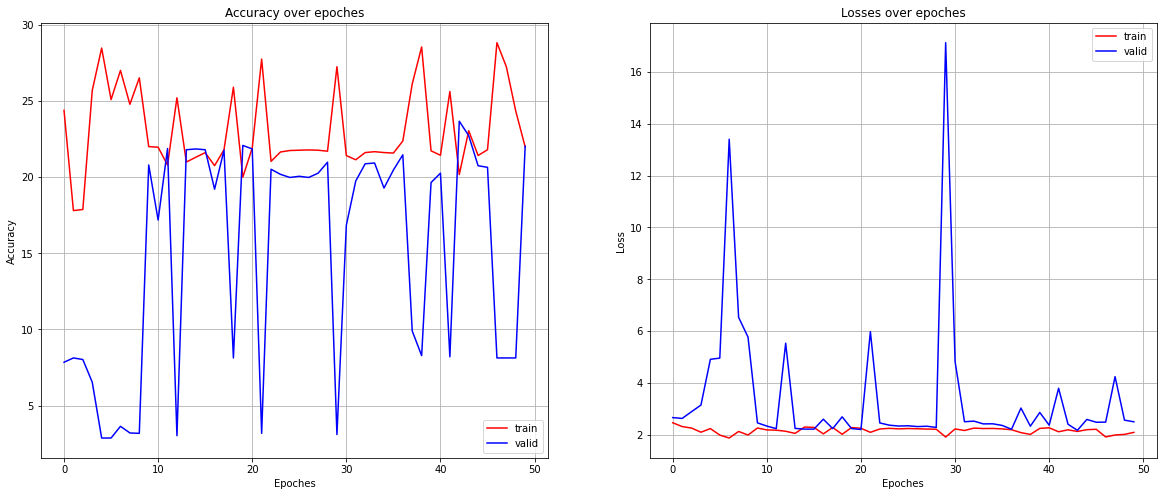

In [18]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy over epoches")
plt.plot(acc_record, 'r',label='train')
plt.plot(valid_acc_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Losses over epoches")
plt.plot(loss_record, 'r',label='train')
plt.plot(valid_loss_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# test the model
import sklearn.metrics as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns

def valid(data_loader, model,loss_fn=nn.CrossEntropyLoss()):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0
    targets, preds = [], []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        total_loss += loss.item()
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        targets += list(labels.cpu().numpy())
        preds += list(pred.cpu().numpy())
    test_acc = 100 * correct / total
    print(test_acc)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    precision = precision_score(targets, preds, average='micro')
    recall = recall_score(targets, preds, average='micro')
    f1 = f1_score(targets, preds, average='micro')
    final_loss = total_loss/len(data_loader)
    return test_acc,precision,recall,f1, confusion_mtx, final_loss


def vis(confusion_mtx, labels,figsize=(15, 15)):
    cm = confusion_mtx
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p,c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig = plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues")
    plt.show()

34.55349959774738
Accuracy: 34.55
Precision: 0.35
Recall: 0.35
F1 Score: 0.35
Loss: 2.49


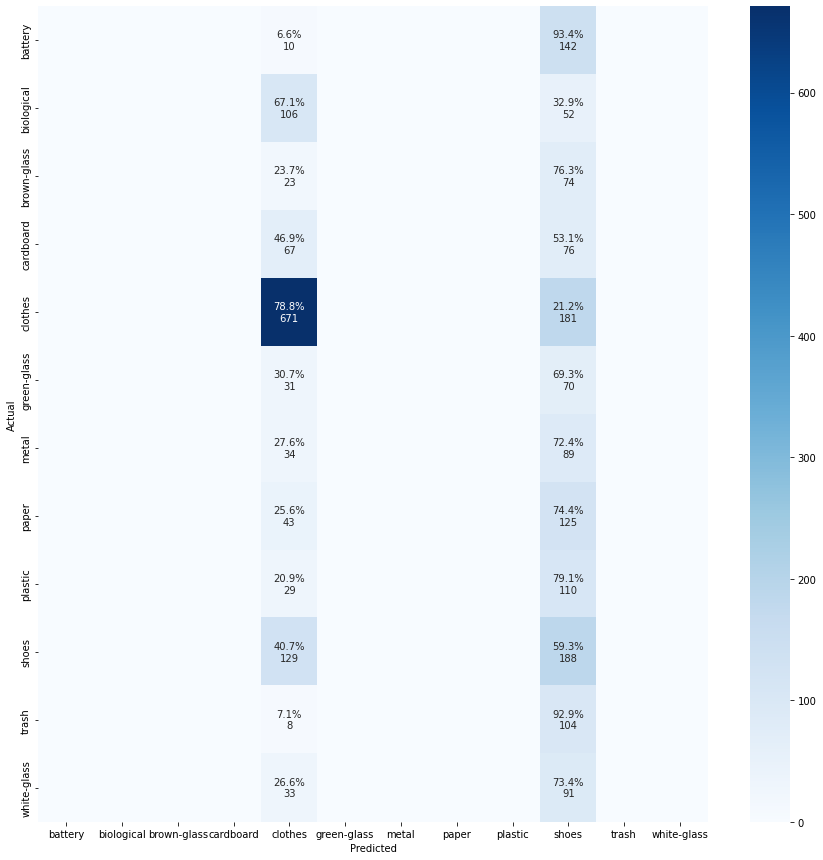

In [48]:
accuracy,precision,recall,f1, confusion_mtx, loss = valid(valid_loader, model)
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Loss: {:.2f}".format(loss))
vis(confusion_mtx, list(categories.keys()))

# The first optimization

In [21]:
# create a new dataloader with balance sampler
train_loader_update_1 = torch.utils.data.DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data),batch_size=batch_size)

Epoch [9920/10000]: 100%|██████████| 156/156 [00:03<00:00, 49.14it/s]


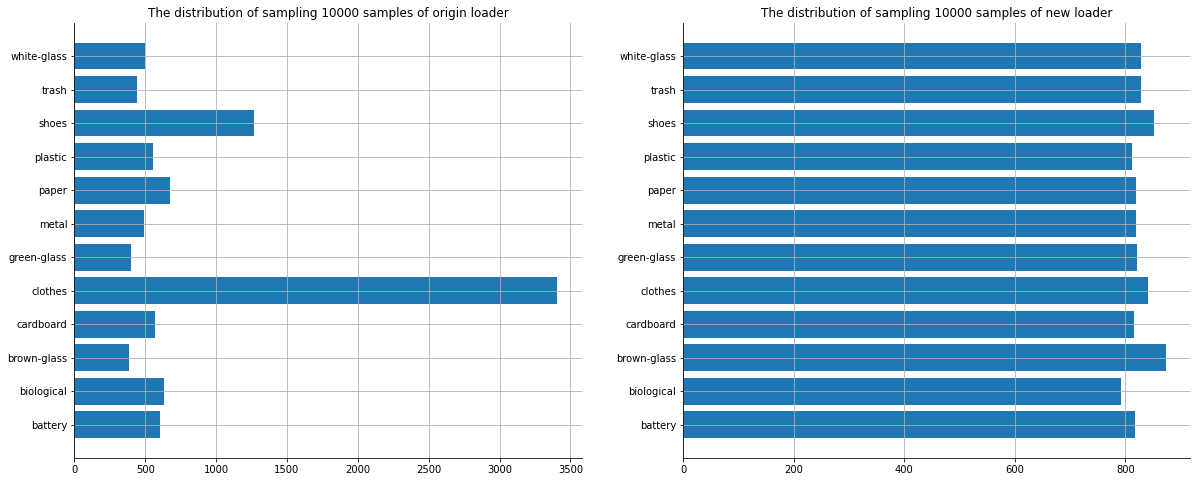

In [22]:
# test new data loader
sample_num = 10000

count_origin_dic = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
    11: 0
}
loop = tqdm(train_loader)
for batch_idx, (data, target) in enumerate(loop):
    for label in target:
        count_origin_dic[label.item()] += 1
    loop.set_description(f"Epoch [{batch_idx*batch_size}/{sample_num}]")
    if batch_idx*batch_size >= sample_num:
        break


count_dic = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
    11: 0
}
loop = tqdm(train_loader_update_1)
for batch_idx, (data, target) in enumerate(loop):
    for label in target:
        count_dic[label.item()] += 1
    loop.set_description(f"Epoch [{batch_idx*batch_size}/{sample_num}]")
    if batch_idx*batch_size >= sample_num:
        break

fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("The distribution of sampling 10000 samples of origin loader")
bar = plt.barh(list(categories.keys()),list(count_origin_dic.values()))
# plt.bar_label(bar, label_type='edge')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("The distribution of sampling 10000 samples of new loader")
bar = plt.barh(list(categories.keys()),list(count_dic.values()))
# plt.bar_label(bar, label_type='edge')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True)
plt.show()

In [34]:
# train the model
model_update_1 = Resnet(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)
loss_record, acc_record,valid_loss_record,valid_acc_record = train(train_loader_update_1,valid_loader, model_update_1, epochs=50)


Epoch [2/50]:   1%|▏         | 2/156 [00:00<00:13, 11.07it/s, acc=0.5, loss=1.49]

Epoch 1/50, Loss: 1.557851364215215|1.7193983869674878(valid), Acc: 30.46794891357422


Epoch [3/50]:   1%|▏         | 2/156 [00:00<00:13, 11.47it/s, acc=0.516, loss=1.57]

Epoch 2/50, Loss: 1.2577791722157063|1.7091210667903607(valid), Acc: 36.903846740722656


Epoch [4/50]:   1%|▏         | 2/156 [00:00<00:13, 11.39it/s, acc=0.562, loss=1.17]

Epoch 3/50, Loss: 1.1758154340279408|1.278078447931852(valid), Acc: 38.25


Epoch [5/50]:   1%|▏         | 2/156 [00:00<00:13, 11.48it/s, acc=0.656, loss=1.1]

Epoch 4/50, Loss: 1.0482450593740513|1.3804363868175409(valid), Acc: 41.02564239501953


Epoch [6/50]:   1%|          | 1/156 [00:00<00:17,  8.79it/s, acc=0.672, loss=1.07] 

Epoch 5/50, Loss: 0.9951275759018384|0.9624790816734998(valid), Acc: 42.31410217285156


Epoch [7/50]:   1%|▏         | 2/156 [00:00<00:13, 11.58it/s, acc=0.688, loss=0.797]

Epoch 6/50, Loss: 0.8865538950149829|1.1102795585607872(valid), Acc: 44.410255432128906


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7/50, Loss: 0.8380329872553165|1.1906930552079127(valid), Acc: 45.871795654296875


Epoch [9/50]:   1%|▏         | 2/156 [00:00<00:11, 13.36it/s, acc=0.75, loss=0.825]

Epoch 8/50, Loss: 0.8170201432628509|1.2952742301500761(valid), Acc: 46.153846740722656


Epoch [10/50]:   1%|▏         | 2/156 [00:00<00:11, 13.34it/s, acc=0.766, loss=0.767]

Epoch 9/50, Loss: 0.7236339321885353|1.6784950647598658(valid), Acc: 48.36538314819336


Epoch [11/50]:   1%|▏         | 2/156 [00:00<00:11, 13.51it/s, acc=0.656, loss=0.988]

Epoch 10/50, Loss: 0.6759376743665109|1.3322293949432862(valid), Acc: 49.38461685180664


Epoch [12/50]:   1%|▏         | 2/156 [00:00<00:11, 13.37it/s, acc=0.828, loss=0.522]

Epoch 11/50, Loss: 0.6157547151431059|1.3228467817489917(valid), Acc: 50.80769348144531


Epoch [13/50]:   1%|          | 1/156 [00:00<00:16,  9.51it/s, acc=0.734, loss=0.761]

Epoch 12/50, Loss: 0.5753884943058858|1.7220633266827998(valid), Acc: 51.29487228393555


Epoch [14/50]:   1%|▏         | 2/156 [00:00<00:11, 13.00it/s, acc=0.859, loss=0.43]

Epoch 13/50, Loss: 0.47049268048543197|0.963630613608238(valid), Acc: 53.53845977783203


Epoch [15/50]:   1%|▏         | 2/156 [00:00<00:11, 13.23it/s, acc=0.859, loss=0.42]

Epoch 14/50, Loss: 0.3814252743927332|0.8084118511432257(valid), Acc: 55.58333206176758


Epoch [16/50]:   1%|▏         | 2/156 [00:00<00:11, 12.89it/s, acc=0.953, loss=0.234]

Epoch 15/50, Loss: 0.35643296110897493|1.279295877004281(valid), Acc: 56.25


Epoch [17/50]:   1%|▏         | 2/156 [00:00<00:11, 13.18it/s, acc=0.859, loss=0.411]

Epoch 16/50, Loss: 0.38961316435000837|0.9206563635514333(valid), Acc: 55.839744567871094


Epoch [18/50]:   1%|▏         | 2/156 [00:00<00:11, 13.69it/s, acc=0.844, loss=0.372]

Epoch 17/50, Loss: 0.31043077604128766|0.9654422448231623(valid), Acc: 57.1987190246582


Epoch [19/50]:   1%|▏         | 2/156 [00:00<00:11, 13.84it/s, acc=0.969, loss=0.0944]

Epoch 18/50, Loss: 0.23430940535110542|0.7571494835309494(valid), Acc: 58.660255432128906


Epoch [20/50]:   1%|          | 1/156 [00:00<00:28,  5.49it/s, acc=0.969, loss=0.101]

Epoch 19/50, Loss: 0.16944563801949605|0.9285106731530948(valid), Acc: 60.57692337036133


Epoch [21/50]:   1%|▏         | 2/156 [00:00<00:12, 12.82it/s, acc=0.984, loss=0.111]

Epoch 20/50, Loss: 0.2055385258908455|0.8848147361706464(valid), Acc: 59.42307662963867


Epoch [22/50]:   1%|▏         | 2/156 [00:00<00:11, 13.43it/s, acc=0.875, loss=0.292]

Epoch 21/50, Loss: 0.10095635980654222|1.0487885475158691(valid), Acc: 61.78205108642578


Epoch [23/50]:   1%|▏         | 2/156 [00:00<00:11, 13.39it/s, acc=0.922, loss=0.273]

Epoch 22/50, Loss: 0.17241823206393|0.9997977713743845(valid), Acc: 60.39743423461914


Epoch [24/50]:   1%|▏         | 2/156 [00:00<00:11, 13.79it/s, acc=0.859, loss=0.42]

Epoch 23/50, Loss: 0.1847902532810202|1.9810072290591705(valid), Acc: 59.91666793823242


Epoch [25/50]:   1%|▏         | 2/156 [00:00<00:11, 13.46it/s, acc=0.953, loss=0.123]

Epoch 24/50, Loss: 0.32446118355848086|0.7961636210481325(valid), Acc: 57.64743423461914


Epoch [26/50]:   1%|▏         | 2/156 [00:00<00:11, 13.04it/s, acc=1, loss=0.0328]

Epoch 25/50, Loss: 0.21719704803604728|0.8422984381516775(valid), Acc: 59.41666793823242


Epoch [27/50]:   1%|▏         | 2/156 [00:00<00:11, 13.50it/s, acc=0.953, loss=0.141]

Epoch 26/50, Loss: 0.07241532344442721|0.8059534606261131(valid), Acc: 62.403846740722656


Epoch [28/50]:   1%|▏         | 2/156 [00:00<00:11, 13.82it/s, acc=0.984, loss=0.0706]

Epoch 27/50, Loss: 0.12945774100565663|0.9724978460715368(valid), Acc: 61.410255432128906


Epoch [29/50]:   1%|▏         | 2/156 [00:00<00:11, 13.68it/s, acc=0.938, loss=0.181]

Epoch 28/50, Loss: 0.1517703317416211|0.8234445681938758(valid), Acc: 60.67948532104492


Epoch [30/50]:   1%|▏         | 2/156 [00:00<00:11, 13.70it/s, acc=0.969, loss=0.0939]

Epoch 29/50, Loss: 0.08222349937587307|0.8910703808069229(valid), Acc: 62.25640869140625


Epoch [31/50]:   1%|▏         | 2/156 [00:00<00:11, 13.50it/s, acc=0.984, loss=0.0577]

Epoch 30/50, Loss: 0.10819279569654892|0.935372606301919(valid), Acc: 61.66666793823242


Epoch [32/50]:   1%|          | 1/156 [00:00<00:27,  5.55it/s, acc=0.938, loss=0.143]

Epoch 31/50, Loss: 0.1169519861563085|0.80888376193933(valid), Acc: 61.27564239501953


Epoch [33/50]:   1%|▏         | 2/156 [00:00<00:12, 12.63it/s, acc=0.984, loss=0.035]

Epoch 32/50, Loss: 0.029546219765996702|0.7587386427017359(valid), Acc: 63.06410217285156


Epoch [34/50]:   1%|▏         | 2/156 [00:00<00:11, 13.89it/s, acc=0.969, loss=0.367]

Epoch 33/50, Loss: 0.02713992547852775|0.8817479127110579(valid), Acc: 63.24359130859375


Epoch [35/50]:   1%|▏         | 2/156 [00:00<00:11, 13.72it/s, acc=0.938, loss=0.0956]

Epoch 34/50, Loss: 0.1063170767425058|1.211071143547694(valid), Acc: 61.628204345703125


Epoch [36/50]:   1%|▏         | 2/156 [00:00<00:13, 11.67it/s, acc=0.969, loss=0.066]

Epoch 35/50, Loss: 0.13943468865890724|0.9667150053458337(valid), Acc: 60.81410217285156


Epoch [37/50]:   1%|▏         | 2/156 [00:00<00:12, 12.73it/s, acc=0.969, loss=0.0654]

Epoch 36/50, Loss: 0.06145559253099446|0.95887247301065(valid), Acc: 62.39743423461914


Epoch [38/50]:   1%|▏         | 2/156 [00:00<00:11, 13.57it/s, acc=1, loss=0.0104]

Epoch 37/50, Loss: 0.11248088650441226|0.8280263168689532(valid), Acc: 61.60256576538086


Epoch [39/50]:   1%|▏         | 2/156 [00:00<00:12, 12.36it/s, acc=0.922, loss=0.192]

Epoch 38/50, Loss: 0.0894240197749474|0.9135898578052337(valid), Acc: 62.11538314819336


Epoch [40/50]:   1%|▏         | 2/156 [00:00<00:11, 13.70it/s, acc=1, loss=0.0242]

Epoch 39/50, Loss: 0.16103204855253586|0.9918873936702044(valid), Acc: 60.628204345703125


Epoch [41/50]:   1%|▏         | 2/156 [00:00<00:11, 13.07it/s, acc=0.984, loss=0.0391]

Epoch 40/50, Loss: 0.052241939321482696|0.7892021473783714(valid), Acc: 62.69230651855469


Epoch [42/50]:   1%|▏         | 2/156 [00:00<00:12, 12.20it/s, acc=0.969, loss=0.097]

Epoch 41/50, Loss: 0.03321834717345878|0.8665893929891098(valid), Acc: 63.08333206176758


Epoch [43/50]:   1%|▏         | 2/156 [00:00<00:11, 13.48it/s, acc=0.984, loss=0.0352]

Epoch 42/50, Loss: 0.055768921478794746|0.8676436379169806(valid), Acc: 62.54487228393555


Epoch [44/50]:   1%|          | 1/156 [00:00<00:27,  5.61it/s, acc=0.984, loss=0.0213]

Epoch 43/50, Loss: 0.04319242587930953|0.8160858484796989(valid), Acc: 62.77564239501953


Epoch [45/50]:   1%|▏         | 2/156 [00:00<00:11, 13.43it/s, acc=0.969, loss=0.407]

Epoch 44/50, Loss: 0.02224850715608157|1.193683159704774(valid), Acc: 63.42948532104492


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 45/50, Loss: 0.14289387666548675|0.8589442041821969(valid), Acc: 61.096153259277344


Epoch [47/50]:   1%|▏         | 2/156 [00:00<00:11, 13.35it/s, acc=1, loss=0.00929]

Epoch 46/50, Loss: 0.04211693126648569|0.8628919507878331(valid), Acc: 62.85897445678711


Epoch [48/50]:   1%|▏         | 2/156 [00:00<00:11, 13.11it/s, acc=1, loss=0.00827]

Epoch 47/50, Loss: 0.010085346431692298|0.8426368492536056(valid), Acc: 63.47435760498047


Epoch [49/50]:   1%|▏         | 2/156 [00:00<00:11, 13.10it/s, acc=1, loss=0.00513]

Epoch 48/50, Loss: 0.00961512934195642|0.8890353905944488(valid), Acc: 63.45512771606445


Epoch [50/50]:   1%|▏         | 2/156 [00:00<00:11, 13.68it/s, acc=1, loss=0.00297]

Epoch 49/50, Loss: 0.030507138681012947|0.9703253397288231(valid), Acc: 62.987178802490234


100%|██████████| 39/39 [00:02<00:00, 14.85it/s]


Epoch 50/50, Loss: 0.007066380952892359|0.9553000255463979(valid), Acc: 63.49359130859375


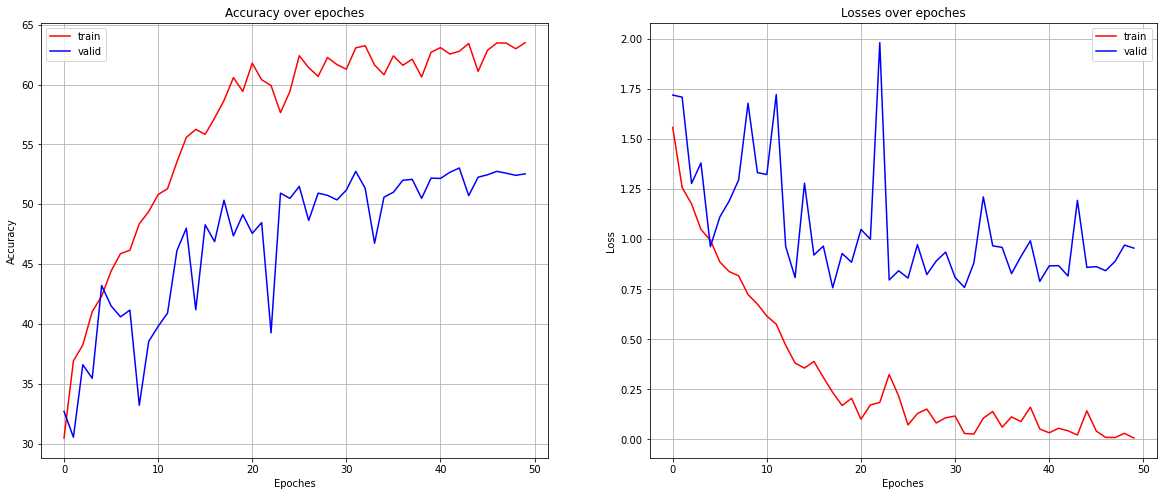

In [35]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy over epoches")
plt.plot(acc_record, 'r',label='train')
plt.plot(valid_acc_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Losses over epoches")
plt.plot(loss_record, 'r',label='train')
plt.plot(valid_loss_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

82.42156074014481
Accuracy: 82.42
Precision: 0.82
Recall: 0.82
F1 Score: 0.82
Loss: 37.26


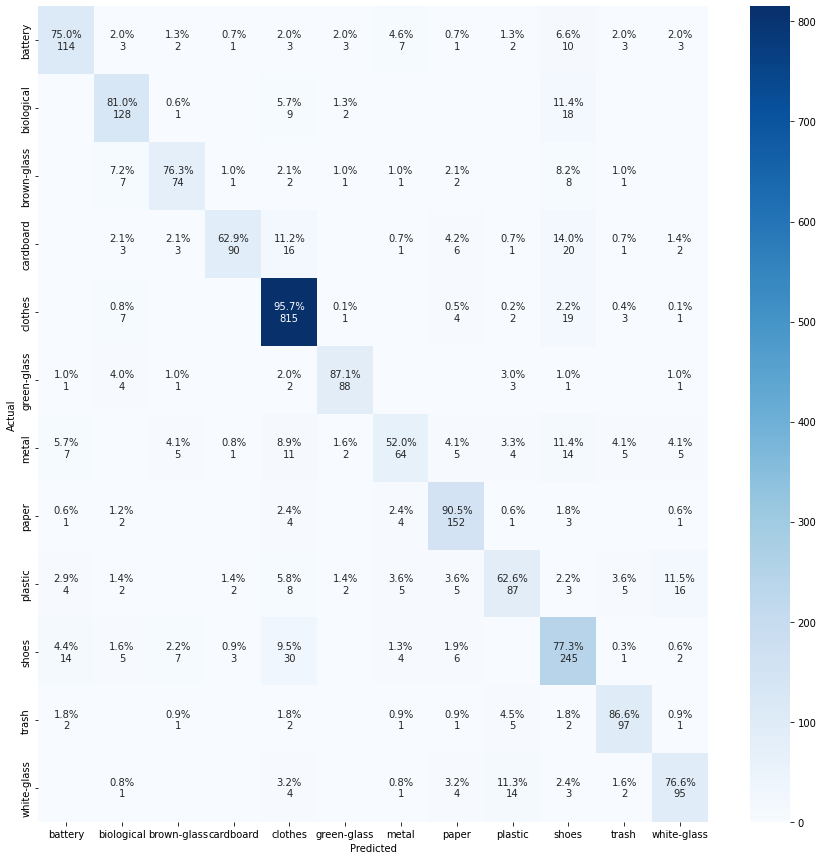

In [36]:
# valid the new model
accuracy,precision,recall,f1, confusion_mtx, loss = valid(valid_loader, model_update_1)
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Loss: {:.2f}".format(loss))
vis(confusion_mtx, list(categories.keys()))

82.64649066323246
Accuracy: 82.65
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
Loss: 0.97


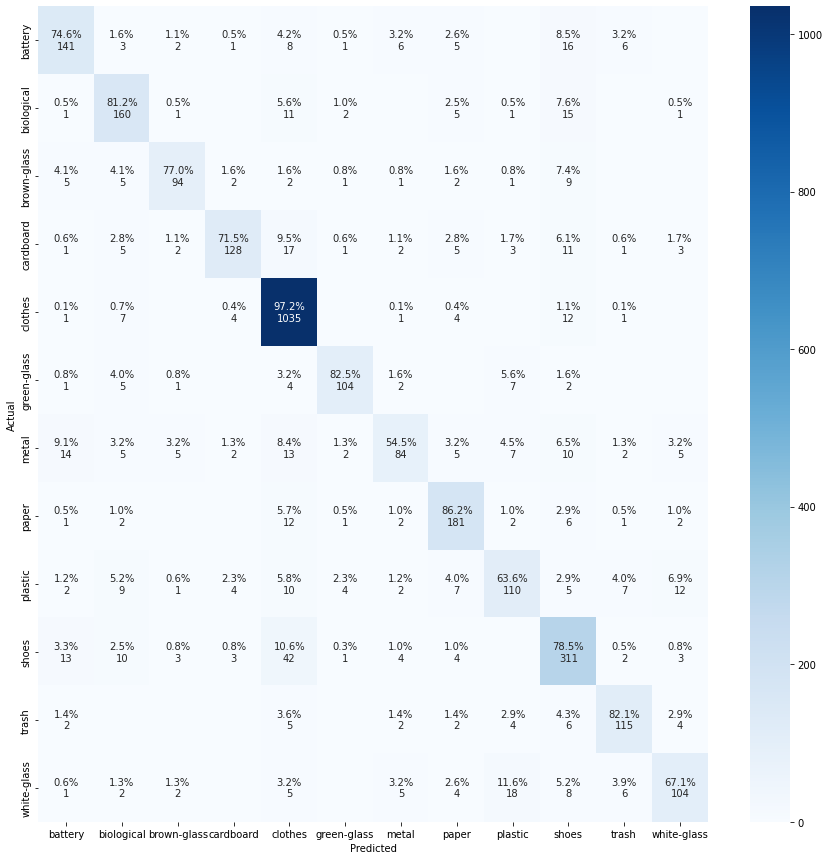

In [49]:
# test the new model
accuracy,precision,recall,f1, confusion_mtx, loss = valid(test_loader, model_update_1)
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Loss: {:.2f}".format(loss))
vis(confusion_mtx, list(categories.keys()))

换一个带dropout的模型

In [38]:

class Resnet_dropout(nn.Module):
    # 224*224
    def __init__(self, block, num_layer, n_classes=1000, input_channels=3):
        super(Resnet_dropout, self).__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d(224)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_layer[0])
        self.layer2 = self._make_layer(block, 128, num_layer[1], 2)
        self.layer3 = self._make_layer(block, 256, num_layer[2], 2)
        self.layer4 = self._make_layer(block, 512, num_layer[3], 2)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc = nn.Linear(block.expansion * 512, n_classes)
        self.dropout =  nn.Dropout(0.25)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def _make_layer(self, block, out_channels, num_block, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_block):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.dropout(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [39]:
# train the model
model_update_3 = Resnet_dropout(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)
loss_record, acc_record,valid_loss_record,valid_acc_record = train(train_loader_update_1,valid_loader, model_update_3, epochs=50)

Epoch [2/50]:   1%|          | 1/156 [00:00<00:15,  9.83it/s, acc=0.469, loss=1.39]

Epoch 1/50, Loss: 1.5952006578445435|2.04119603908979(valid), Acc: 29.08333396911621


Epoch [3/50]:   1%|▏         | 2/156 [00:00<00:12, 12.51it/s, acc=0.484, loss=1.46]

Epoch 2/50, Loss: 1.3490150005389483|1.7803279604667273(valid), Acc: 34.42948532104492


Epoch [4/50]:   1%|▏         | 2/156 [00:00<00:11, 12.96it/s, acc=0.438, loss=1.31]

Epoch 3/50, Loss: 1.2330848154349205|3.52614715275092(valid), Acc: 36.987178802490234


Epoch [5/50]:   1%|▏         | 2/156 [00:00<00:13, 11.37it/s, acc=0.578, loss=1.13]

Epoch 4/50, Loss: 1.090444945754149|1.9837767733977392(valid), Acc: 40.42948532104492


Epoch [6/50]:   1%|▏         | 2/156 [00:00<00:11, 13.02it/s, acc=0.516, loss=1.19]

Epoch 5/50, Loss: 1.0357997604669669|1.7473584161354945(valid), Acc: 41.60897445678711


Epoch [7/50]:   1%|▏         | 2/156 [00:00<00:11, 13.30it/s, acc=0.672, loss=0.979]

Epoch 6/50, Loss: 0.9980054513002053|1.9104547473864677(valid), Acc: 42.237178802490234


Epoch [8/50]:   1%|▏         | 2/156 [00:00<00:11, 12.95it/s, acc=0.703, loss=0.999]

Epoch 7/50, Loss: 0.9149351899440472|1.8323079019020765(valid), Acc: 44.0


Epoch [9/50]:   1%|▏         | 2/156 [00:00<00:11, 13.41it/s, acc=0.594, loss=0.931]

Epoch 8/50, Loss: 0.8873229309534415|1.0641155785475023(valid), Acc: 44.08333206176758


Epoch [10/50]:   1%|▏         | 2/156 [00:00<00:11, 13.80it/s, acc=0.844, loss=0.427]

Epoch 9/50, Loss: 0.8136788602822866|0.9129736270660009(valid), Acc: 45.97435760498047


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.7537835053144357|3.6343000122369866(valid), Acc: 47.56410217285156


Epoch [12/50]:   1%|▏         | 2/156 [00:00<00:11, 13.57it/s, acc=0.812, loss=0.526]

Epoch 11/50, Loss: 0.742498218249052|1.4474829412423647(valid), Acc: 47.50640869140625


Epoch [13/50]:   1%|▏         | 2/156 [00:00<00:11, 12.93it/s, acc=0.797, loss=0.645]

Epoch 12/50, Loss: 0.6919390742595379|1.1729684900014827(valid), Acc: 48.97435760498047


Epoch [14/50]:   1%|▏         | 2/156 [00:00<00:12, 12.01it/s, acc=0.812, loss=0.583]

Epoch 13/50, Loss: 0.6305227063787289|1.1924659747343798(valid), Acc: 49.93589782714844


Epoch [15/50]:   1%|▏         | 2/156 [00:00<00:11, 13.35it/s, acc=0.859, loss=0.465]

Epoch 14/50, Loss: 0.5547830182581376|2.1001140284232602(valid), Acc: 51.75


Epoch [16/50]:   1%|▏         | 2/156 [00:00<00:11, 13.81it/s, acc=0.844, loss=0.492]

Epoch 15/50, Loss: 0.5188850578016195|0.8599428542149372(valid), Acc: 52.42948532104492


Epoch [17/50]:   1%|▏         | 2/156 [00:00<00:11, 12.88it/s, acc=0.859, loss=0.494]

Epoch 16/50, Loss: 0.432911928361043|1.2712832402724485(valid), Acc: 54.42307662963867


Epoch [18/50]:   1%|▏         | 2/156 [00:00<00:11, 13.58it/s, acc=0.844, loss=0.492]

Epoch 17/50, Loss: 0.43208862153383404|1.59624271438672(valid), Acc: 54.839744567871094


Epoch [19/50]:   1%|▏         | 2/156 [00:00<00:13, 11.53it/s, acc=0.859, loss=0.317]

Epoch 18/50, Loss: 0.4048342652236804|0.9608852855670147(valid), Acc: 55.14743423461914


Epoch [20/50]:   1%|▏         | 2/156 [00:00<00:11, 12.91it/s, acc=0.906, loss=0.273]

Epoch 19/50, Loss: 0.32845015522952264|0.8303594621710289(valid), Acc: 56.88461685180664


Epoch [21/50]:   1%|▏         | 2/156 [00:00<00:11, 13.02it/s, acc=0.797, loss=0.467]

Epoch 20/50, Loss: 0.33572539548652297|0.8332344278311118(valid), Acc: 56.371795654296875


Epoch [22/50]:   1%|          | 1/156 [00:00<00:27,  5.56it/s, acc=0.906, loss=0.275]

Epoch 21/50, Loss: 0.229784786557922|0.9590676980905044(valid), Acc: 58.72435760498047


Epoch [23/50]:   1%|▏         | 2/156 [00:00<00:11, 13.26it/s, acc=0.938, loss=0.193]

Epoch 22/50, Loss: 0.298970370941485|0.821692671531286(valid), Acc: 57.378204345703125


Epoch [24/50]:   1%|▏         | 2/156 [00:00<00:11, 12.94it/s, acc=0.859, loss=0.38]

Epoch 23/50, Loss: 0.18689691540426934|1.1924684296051662(valid), Acc: 60.096153259277344


Epoch [25/50]:   1%|▏         | 2/156 [00:00<00:12, 12.14it/s, acc=0.953, loss=0.195]

Epoch 24/50, Loss: 0.3628491327071037|0.9077029816615276(valid), Acc: 56.72435760498047


Epoch [26/50]:   1%|          | 1/156 [00:00<00:16,  9.30it/s, acc=0.984, loss=0.107]

Epoch 25/50, Loss: 0.2336145433334586|0.6973258419296681(valid), Acc: 58.82051467895508


Epoch [27/50]:   1%|▏         | 2/156 [00:00<00:12, 12.72it/s, acc=0.953, loss=0.143]

Epoch 26/50, Loss: 0.19308361845711866|0.6967301819569025(valid), Acc: 59.628204345703125


Epoch [28/50]:   1%|▏         | 2/156 [00:00<00:12, 12.20it/s, acc=0.984, loss=0.0508]

Epoch 27/50, Loss: 0.11306410655379295|0.9435436450518094(valid), Acc: 61.14102554321289


Epoch [29/50]:   1%|▏         | 2/156 [00:00<00:11, 13.27it/s, acc=0.984, loss=0.0909]

Epoch 28/50, Loss: 0.09427308190303545|0.7817338869357721(valid), Acc: 61.730770111083984


Epoch [30/50]:   1%|▏         | 2/156 [00:00<00:12, 12.76it/s, acc=0.969, loss=0.104]

Epoch 29/50, Loss: 0.11301997447243103|0.7327898354866565(valid), Acc: 61.32051467895508


Epoch [31/50]:   1%|▏         | 2/156 [00:00<00:12, 12.45it/s, acc=0.906, loss=0.325]

Epoch 30/50, Loss: 0.08199272011944021|1.0891253084708483(valid), Acc: 62.096153259277344


Epoch [32/50]:   1%|          | 1/156 [00:00<00:28,  5.45it/s, acc=0.953, loss=0.15]

Epoch 31/50, Loss: 0.23219214958879045|0.9253152280281751(valid), Acc: 59.03845977783203


Epoch [33/50]:   1%|          | 1/156 [00:00<00:15,  9.89it/s, acc=1, loss=0.017]     

Epoch 32/50, Loss: 0.1050835688574574|0.9734701187564776(valid), Acc: 61.58333206176758


Epoch [34/50]:   1%|▏         | 2/156 [00:00<00:12, 12.09it/s, acc=0.969, loss=0.159]

Epoch 33/50, Loss: 0.06299029872752726|0.793102000768368(valid), Acc: 62.52564239501953


Epoch [35/50]:   1%|▏         | 2/156 [00:00<00:11, 13.32it/s, acc=0.969, loss=0.0768]

Epoch 34/50, Loss: 0.22160924304849827|0.8222950437130072(valid), Acc: 59.46794891357422


Epoch [36/50]:   1%|▏         | 2/156 [00:00<00:11, 13.40it/s, acc=0.984, loss=0.0481]

Epoch 35/50, Loss: 0.1719790130901413|0.825756332431084(valid), Acc: 60.3012809753418


Epoch [37/50]:   1%|▏         | 2/156 [00:00<00:11, 13.26it/s, acc=0.984, loss=0.0494]

Epoch 36/50, Loss: 0.1316232037348434|0.6846372068692477(valid), Acc: 61.07692337036133


Epoch [38/50]:   1%|▏         | 2/156 [00:00<00:11, 13.28it/s, acc=1, loss=0.0216]

Epoch 37/50, Loss: 0.05534096660976035|0.6994279905771598(valid), Acc: 62.660255432128906


Epoch [39/50]:   1%|▏         | 2/156 [00:00<00:11, 13.42it/s, acc=0.984, loss=0.0464]

Epoch 38/50, Loss: 0.04246656064135142|0.7189806061677444(valid), Acc: 62.85256576538086


Epoch [40/50]:   1%|▏         | 2/156 [00:00<00:12, 12.47it/s, acc=0.906, loss=0.323]

Epoch 39/50, Loss: 0.05293413158655406|1.329160940570709(valid), Acc: 62.81410217285156


Epoch [41/50]:   1%|          | 1/156 [00:00<00:15,  9.97it/s, acc=0.844, loss=0.393]

Epoch 40/50, Loss: 0.1807001216504245|1.0192678696834123(valid), Acc: 60.85256576538086


Epoch [42/50]:   1%|▏         | 2/156 [00:00<00:11, 12.89it/s, acc=0.984, loss=0.0587]

Epoch 41/50, Loss: 0.19879646401088208|0.7466864089171091(valid), Acc: 59.70512771606445


Epoch [43/50]:   1%|▏         | 2/156 [00:00<00:11, 13.49it/s, acc=0.969, loss=0.181]

Epoch 42/50, Loss: 0.053109231834801346|0.7207487408931439(valid), Acc: 62.903846740722656


Epoch [44/50]:   1%|          | 1/156 [00:00<00:28,  5.42it/s, acc=1, loss=0.0359]

Epoch 43/50, Loss: 0.0909401730586512|0.8358911521350726(valid), Acc: 61.92307662963867


Epoch [45/50]:   1%|▏         | 2/156 [00:00<00:12, 12.82it/s, acc=0.969, loss=0.144]

Epoch 44/50, Loss: 0.11887654789592116|1.0188856941576188(valid), Acc: 61.44230651855469


Epoch [46/50]:   1%|▏         | 2/156 [00:00<00:11, 13.11it/s, acc=0.953, loss=0.124]

Epoch 45/50, Loss: 0.16854962476720223|0.9183482130368551(valid), Acc: 60.5


Epoch [47/50]:   1%|▏         | 2/156 [00:00<00:11, 13.00it/s, acc=0.922, loss=0.388]

Epoch 46/50, Loss: 0.14617761468084958|0.8710028452750964(valid), Acc: 61.27564239501953


Epoch [48/50]:   1%|▏         | 2/156 [00:00<00:11, 13.06it/s, acc=0.922, loss=0.142]

Epoch 47/50, Loss: 0.16172060535814708|0.7818743880742636(valid), Acc: 60.596153259277344


Epoch [49/50]:   1%|          | 1/156 [00:00<00:17,  8.71it/s, acc=0.984, loss=0.0189]

Epoch 48/50, Loss: 0.11389246991931055|0.809796942350192(valid), Acc: 61.5512809753418


Epoch [50/50]:   1%|▏         | 2/156 [00:00<00:12, 12.60it/s, acc=1, loss=0.0141]

Epoch 49/50, Loss: 0.07795020698521955|0.8055058696713203(valid), Acc: 62.13461685180664


100%|██████████| 39/39 [00:02<00:00, 14.83it/s]


Epoch 50/50, Loss: 0.022425600012632996|0.7534286832580199(valid), Acc: 63.24359130859375


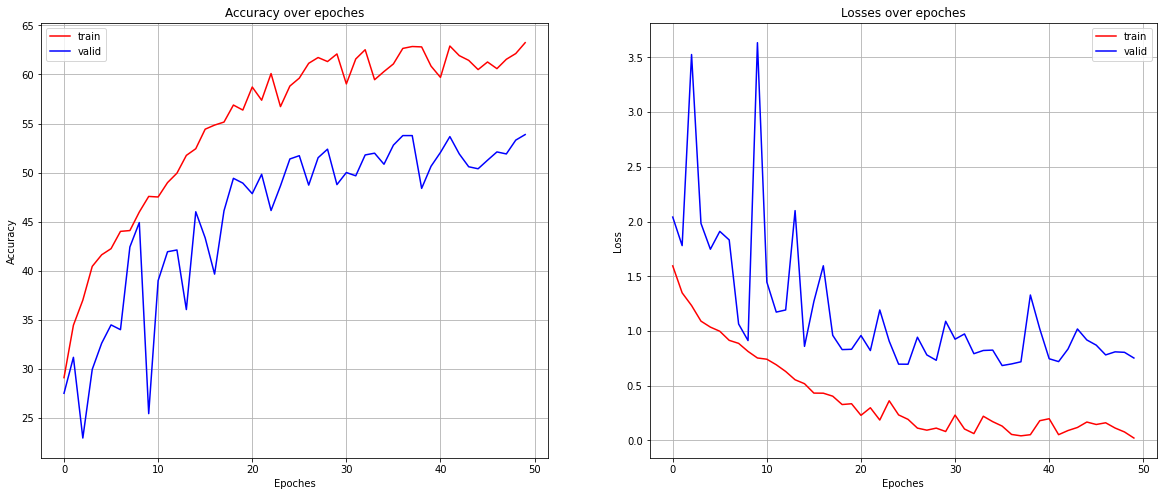

In [40]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy over epoches")
plt.plot(acc_record, 'r',label='train')
plt.plot(valid_acc_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Losses over epoches")
plt.plot(loss_record, 'r',label='train')
plt.plot(valid_loss_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

84.51327433628319
Test Accuracy of the model on the 39 test images: 84.51327433628319 %
Accuracy: 84.51
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


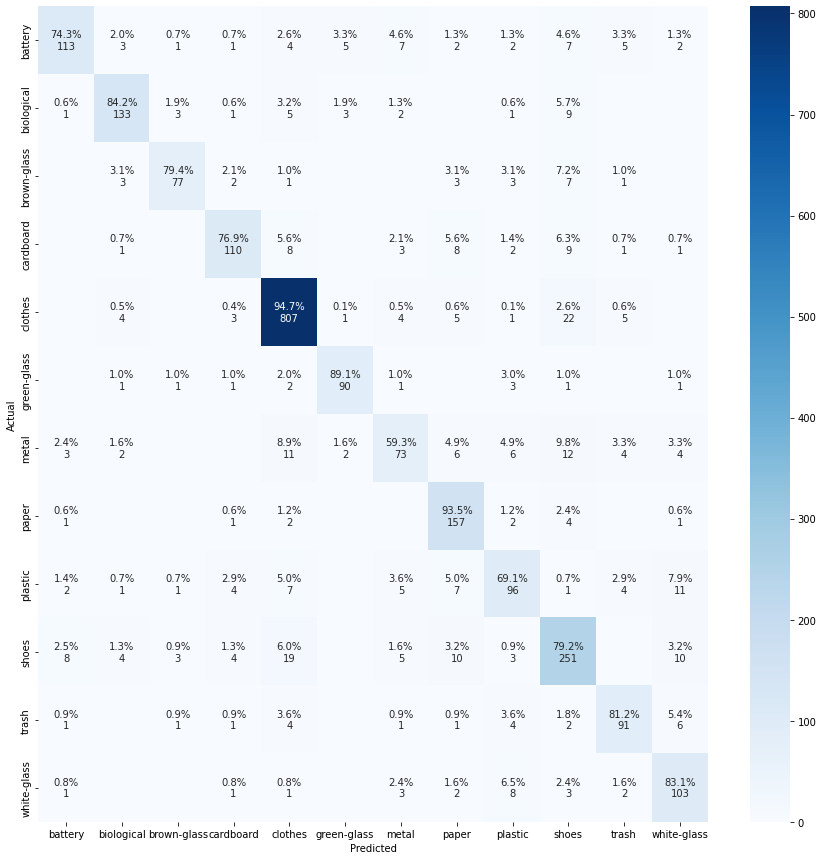

In [41]:
# valid the new model
accuracy,precision,recall,f1, confusion_mtx,loss = valid(valid_loader, model_update_3)
print("Test Accuracy of the model on the {} test images: {} %".format(len(valid_loader), accuracy))
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
vis(confusion_mtx, list(categories.keys()))

83.4835801674179
Accuracy: 83.48
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
Loss: 0.80


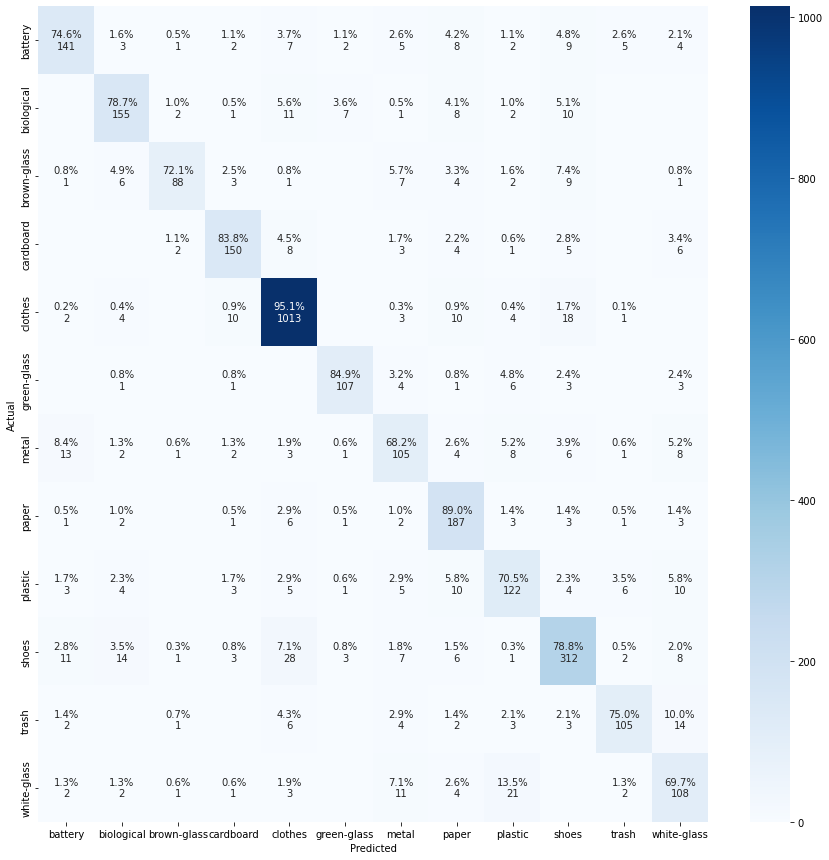

In [50]:
# test the new model
accuracy,precision,recall,f1, confusion_mtx, loss = valid(test_loader, model_update_3)
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Loss: {:.2f}".format(loss))
vis(confusion_mtx, list(categories.keys()))

# 数据集正则化进一步防止overfit

In [51]:
new_transformer = transforms.Compose(
    [
        # data augmentation
        # transforms.RandomRotation(45),  # random rotation from -45 to 45 degrees
        # transforms.RandomHorizontalFlip(
        #     p=0.5
        # ),  # random rotation from probability p
        # transforms.RandomVerticalFlip(
        #     p=0.5
        # ),  # random vertical flip from probability p
        # transforms.ColorJitter(
        #     brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1
        # ),
        # transforms.RandomGrayscale(
        #     p=0.025
        # ),  # randomly transform color to grayscae, R=G=B for 3 channels
        # ritual transformation
        transforms.Resize([256,256]),
        transforms.CenterCrop(224),  # center crop
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
class Dataset_update2(Dataset):
    def __init__(self, txt_path, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        fh = open(txt_path, "r")
        imgs = []
        labels = []
        for line in fh:
            line = line.rstrip()
            words = line.split("/")
            img = Image.open(line).convert(
                "RGB"
            )
            if self.transform is not None:
                img = self.transform(img)
            imgs.append((img, categories[words[1]]))
            labels.append(categories[words[1]])
            self.imgs = imgs
            self.labels = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img, label = self.imgs[
            index
        ]
        return img, label

    def get_labels(self,):
        return self.labels

In [52]:
train_data_update2 = Dataset_update2( txt_path=train_path_file, transform=new_transformer)
train_loader_update2 = torch.utils.data.DataLoader(train_data_update2, sampler=ImbalancedDatasetSampler(train_data_update2), batch_size=128)
# train_loader_update2 = torch.utils.data.DataLoader(train_loader, sampler=ImbalancedDatasetSampler(train_data), batch_size=128)

TypeError: Input tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

In [44]:
# train the model
model_update_2 = Resnet_dropout(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)
# model_update_2 = Resnet(BottleNeck, [3, 4, 6, 3], n_classes=num_classes)
loss_record, acc_record,valid_loss_record,valid_acc_record = train(train_data_update2, valid_loader, model_update_2, epochs=50)

  0%|          | 0/9923 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'to'

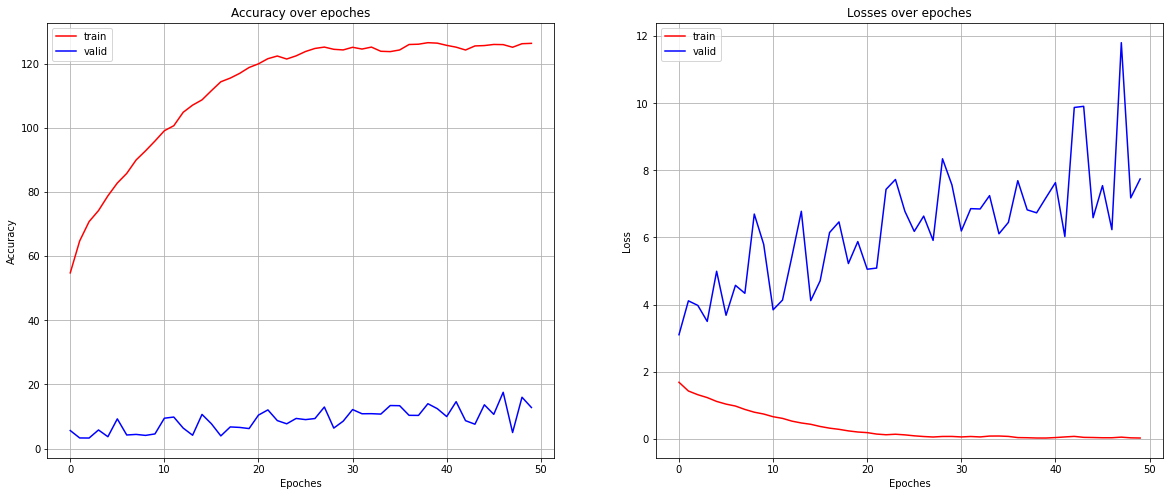

In [ ]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy over epoches")
plt.plot(acc_record, 'r',label='train')
plt.plot(valid_acc_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Losses over epoches")
plt.plot(loss_record, 'r',label='train')
plt.plot(valid_loss_record, 'b',label='valid')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

84.55349959774739
Test Accuracy of the model on the 39 test images: 84.55349959774739 %
Accuracy: 84.55
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


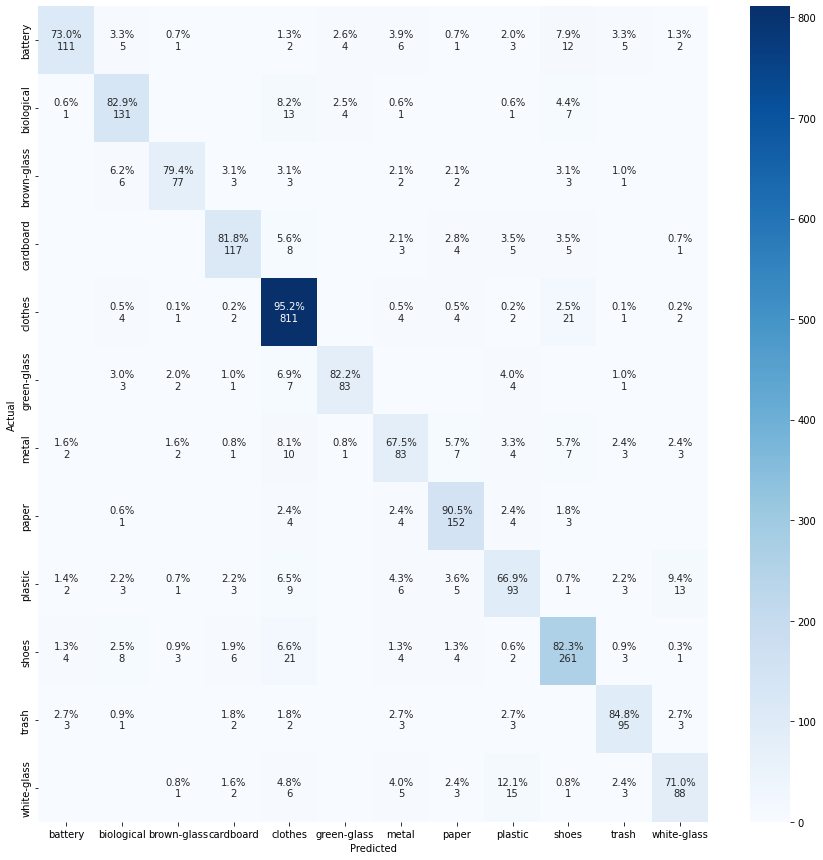

In [ ]:
# valid the new model
accuracy,precision,recall,f1, confusion_mtx,loss = valid(valid_loader, model_update_3)
print("Test Accuracy of the model on the {} test images: {} %".format(len(valid_loader), accuracy))
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
vis(confusion_mtx, list(categories.keys()))